# Titanic EDA — Task 2

Objective: Perform data cleaning and exploratory data analysis (EDA) on a dataset of your choice, such as the Titanic dataset from Kaggle. Explore the relationships between variables and identify patterns and trends in the data.

In [49]:
# imports + load data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
DATA_PATH = r"d:\Prodigy Infotech Data Science Intership\Task 2\test.csv"
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH, "Shape:", df.shape)
df.head()

Loaded: d:\Prodigy Infotech Data Science Intership\Task 2\test.csv Shape: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [50]:
# quick overview

print("Columns:", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)
print("\nMissing counts:\n", df.isna().sum())
display(df.describe(include='all').T)

Columns: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Dtypes:
 PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Missing counts:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,418.0,NaN,NaN,NaN,1100.5,120.810458,892.0,996.25,1100.5,1204.75,1309.0
Pclass,418.0,NaN,NaN,NaN,2.26555,0.841838,1.0,1.0,3.0,3.0,3.0
Name,418,418,"Kelly, Mr. James",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,418,2,male,266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,332.0,NaN,NaN,NaN,30.27259,14.181209,0.17,21.0,27.0,39.0,76.0
SibSp,418.0,NaN,NaN,NaN,0.447368,0.89676,0.0,0.0,0.0,1.0,8.0
Parch,418.0,NaN,NaN,NaN,0.392344,0.981429,0.0,0.0,0.0,0.0,9.0
Ticket,418,363,PC 17608,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,417.0,NaN,NaN,NaN,35.627188,55.907576,0.0,7.8958,14.4542,31.5,512.3292
Cabin,91,76,B57 B59 B63 B66,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# duplicates, basic checks

print("Duplicate rows:", df.duplicated().sum())
print("Sample rows with many missing values:")
display(df[df.isna().sum(axis=1) > 3].head())

Duplicate rows: 0
Sample rows with many missing values:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [52]:
# cleaning function (safe, reproducible)

def clean_titanic(df):
    d = df.copy()
    d = d.drop_duplicates().reset_index(drop=True)

    # extract Title from Name
    if 'Name' in d.columns:
        d['Title'] = d['Name'].astype(str).str.extract(r',\s*([^\.]+)\.', expand=False).str.strip()
        d['Title'] = d['Title'].replace({'Mlle':'Miss','Ms':'Miss','Mme':'Mrs'}).fillna('Unknown')
    
    # family features
    if {'SibSp','Parch'}.issubset(d.columns):
        d['FamilySize'] = d['SibSp'].fillna(0) + d['Parch'].fillna(0) + 1
        d['IsAlone'] = (d['FamilySize']==1).astype(int)
    
    # fill Embarked with mode
    if 'Embarked' in d.columns:
        if d['Embarked'].isna().any():
            d['Embarked'] = d['Embarked'].fillna(d['Embarked'].mode().iloc[0])
    
    # fill Fare with median
    if 'Fare' in d.columns:
        d['Fare'] = d['Fare'].fillna(d['Fare'].median())
    
    # impute Age by group medians then overall median
    if 'Age' in d.columns:
        if {'Pclass','Sex'}.issubset(d.columns):
            d['Age'] = d.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
        if 'Title' in d.columns:
            d['Age'] = d.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
        d['Age'] = d['Age'].fillna(d['Age'].median())
    
    # convert common cats
    for c in ['Pclass','Sex','Embarked','Title']:
        if c in d.columns:
            d[c] = d[c].astype('category')
    return d

dfc = clean_titanic(df)
print("After clean shape:", dfc.shape)
dfc.head()

After clean shape: (418, 14)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,2,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,1,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,3,0


In [53]:
# save cleaned data

OUT_PATH = r"d:\Prodigy Infotech Data Science Intership\Task 2\data\processed\cleaned_test.csv"
import os
os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)
dfc.to_csv(OUT_PATH, index=False)
print("Saved cleaned data to:", OUT_PATH)

Saved cleaned data to: d:\Prodigy Infotech Data Science Intership\Task 2\data\processed\cleaned_test.csv


Missing per column:
 Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

Numeric columns: ['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone']
Categorical columns (sample): ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title']


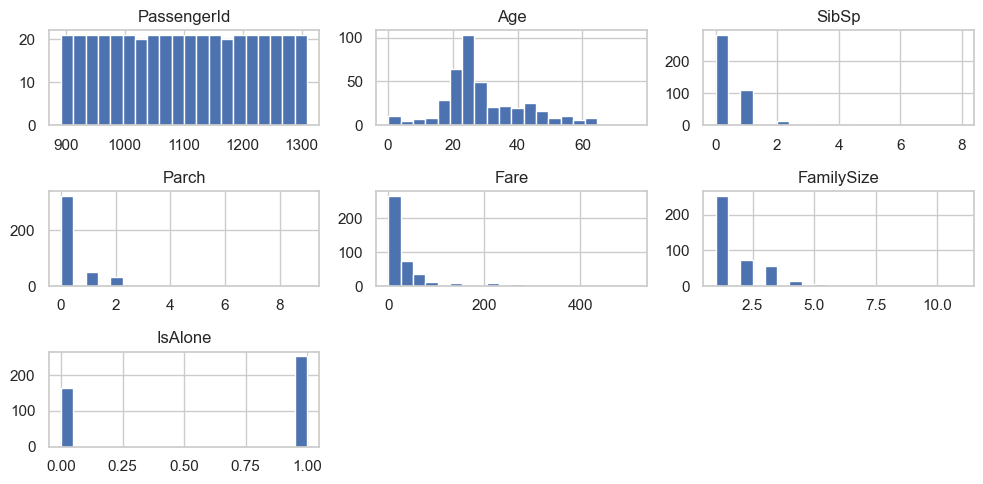

In [54]:
# Missingness and distributions

missing = df.isna().sum().sort_values(ascending=False)
print("Missing per column:\n", missing)

# show distributions
num = dfc.select_dtypes(include=[np.number]).columns.tolist()
cat = dfc.select_dtypes(include=['category','object']).columns.tolist()
print("\nNumeric columns:", num)
print("Categorical columns (sample):", cat[:10])

# quick histograms
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,5)
dfc[num].hist(bins=20)
plt.tight_layout()

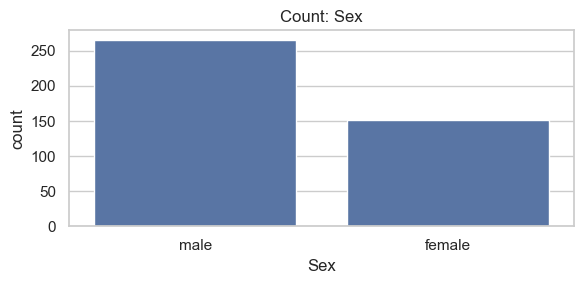

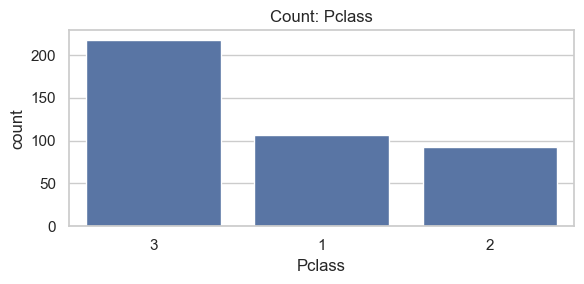

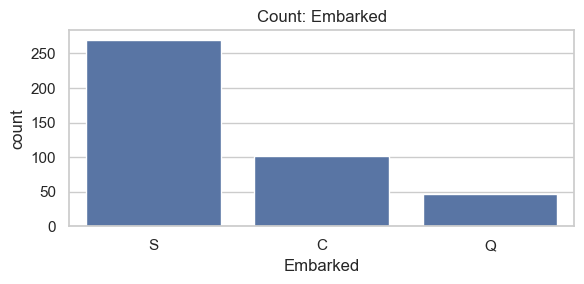

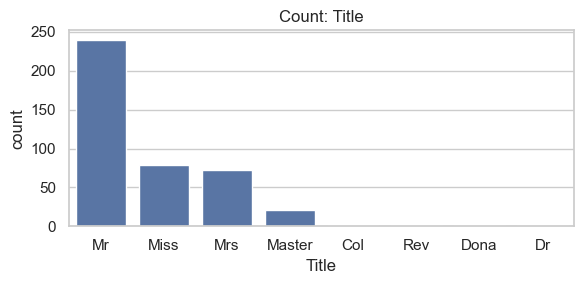

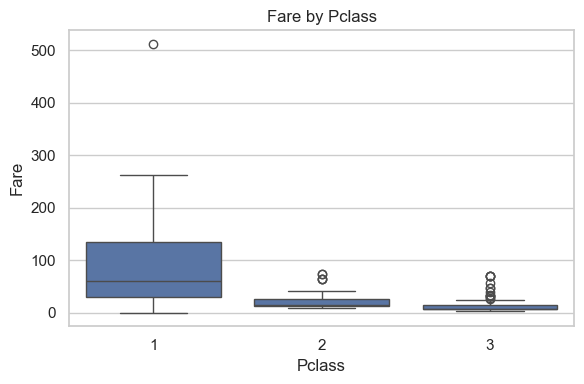

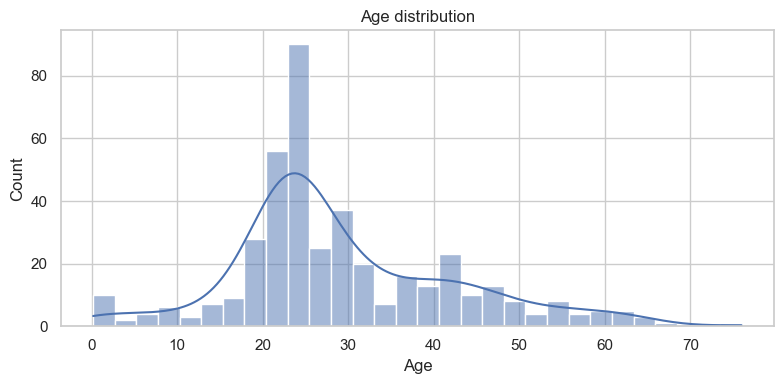

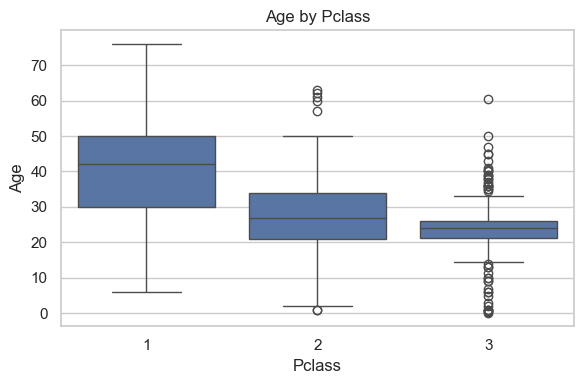

In [55]:
# Categorical counts and key plots

for c in ['Sex','Pclass','Embarked','Title'] :
    if c in dfc.columns:
        plt.figure(figsize=(6,3))
        sns.countplot(x=c, data=dfc, order=dfc[c].value_counts().index)
        plt.title(f'Count: {c}')
        plt.tight_layout()

# Fare by Pclass boxplot
if {'Fare','Pclass'}.issubset(dfc.columns):
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Pclass', y='Fare', data=dfc)
    plt.title('Fare by Pclass')
    plt.tight_layout()

# Age distribution and Age by Pclass
plt.figure(figsize=(8,4))
sns.histplot(dfc['Age'], bins=30, kde=True)
plt.title('Age distribution')
plt.tight_layout()
plt.figure(figsize=(6,4))
if 'Pclass' in dfc.columns:
    sns.boxplot(x='Pclass', y='Age', data=dfc)
    plt.title('Age by Pclass')
    plt.tight_layout()


Median Fare by Pclass & Sex:


Sex,female,male
Pclass,,
1,79.02500,51.8625
2,26.00000,13.0000
3,8.08125,7.8958



Percent alone: 60.53 %


1     253
2      74
3      57
4      14
5       7
6       3
7       4
8       2
11      4
Name: FamilySize, dtype: int64

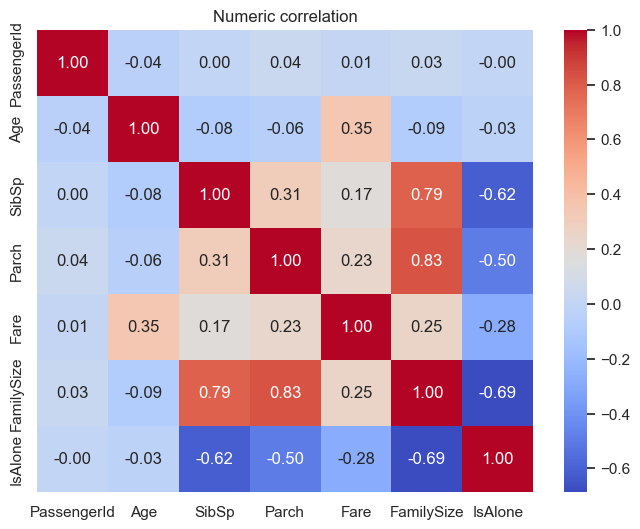

In [56]:
# Relationships and simple summaries

# Correlation of numeric variables
num_df = dfc.select_dtypes(include=[np.number])
if num_df.shape[1] > 1:
    plt.figure(figsize=(8,6))
    sns.heatmap(num_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Numeric correlation')

# Grouped summaries: median Fare by Pclass and Sex
if {'Fare','Pclass','Sex'}.issubset(dfc.columns):
    print("\nMedian Fare by Pclass & Sex:")
    display(dfc.groupby(['Pclass','Sex'])['Fare'].median().unstack())

# Family size / IsAlone stats
if 'IsAlone' in dfc.columns:
    print("\nPercent alone:", round(dfc['IsAlone'].mean()*100,2), "%")
    display(dfc['FamilySize'].value_counts().sort_index().head(10))

In [57]:
# Findings template (copy to report)

"""
## Findings (fill / copy to report)
- Data: rows = {rows}, cols = {cols}
- Missing: main missing columns = Age, Cabin, ... (list counts)
- Cleaning: extracted Title, created FamilySize and IsAlone, imputed Age by Pclass/Sex/Title median, filled Fare with median, filled Embarked with mode.
- Patterns:
- Pclass distribution: (explain)
- Sex distribution: (explain)
- Fare skew: many low fares in Pclass 3, few high in Pclass 1.
- Age: median ~ {age_med}; children concentrated at low ages.
- Family: percent alone ~ {pct_alone}%
- Limitations: this is the Kaggle test set (no Survived target) — merge with train for modeling.
- Next steps: more feature engineering (Cabin deck, Ticket groups), visualization of survival after merging with train, build baseline models.
"""

# After running, update placeholders by printing values:
print("rows,cols:", dfc.shape)
print("median age:", round(dfc['Age'].median(),2))
if 'IsAlone' in dfc.columns:
    print("pct alone:", round(dfc['IsAlone'].mean()*100,2))

rows,cols: (418, 14)
median age: 25.0
pct alone: 60.53


In [58]:
# ...existing code...
# Cell: auto-fill summary and save to file
import os
rows, cols = dfc.shape
miss = df.isna().sum()
age_missing = int(miss.get('Age', 0))
cabin_missing = int(miss.get('Cabin', 0))
emb_mode = dfc['Embarked'].mode().iloc[0] if 'Embarked' in dfc.columns else 'NA'
age_med = round(dfc['Age'].median(), 2) if 'Age' in dfc.columns else 'NA'
pct_alone = round(dfc['IsAlone'].mean()*100, 2) if 'IsAlone' in dfc.columns else 'NA'
sex_counts = dfc['Sex'].value_counts().to_dict() if 'Sex' in dfc.columns else {}
pclass_counts = dfc['Pclass'].value_counts().to_dict() if 'Pclass' in dfc.columns else {}
median_fares = dfc.groupby('Pclass')['Fare'].median().to_dict() if 'Fare' in dfc.columns and 'Pclass' in dfc.columns else {}

summary = f"""# Summary (brief)

- **Objective:** Clean the provided Titanic test.csv and perform EDA to identify relationships and patterns among features.
- **Dataset:** Passenger-level data. Rows: {rows}, Columns: {cols}.

- **Missing values (key):**
- Age: {age_missing} missing (imputed).
- Cabin: {cabin_missing} missing.
- Embarked mode: {emb_mode}.

- **Cleaning steps:** Dropped duplicates, extracted Title, created FamilySize and IsAlone, imputed Age by groups, filled Fare/Embarked, converted categories.

- **Key stats:**
- Median Age (post-impute): {age_med}
- Percent alone: {pct_alone}%
- Sex counts: {sex_counts}
- Pclass counts: {pclass_counts}
- Median Fare by Pclass: {median_fares}

- **High-level findings:** Pclass strongly structures Fare; many passengers travel alone; Cabin is sparse; Title helps group ages.

- **Limitations:** This is the Kaggle test set (no Survived). Imputation adds assumptions.

- **Next steps:** Merge with train.csv for modeling; engineer Cabin deck, Ticket groups, FarePerPerson; run baseline models.
"""

print(summary)

# save markdown
out_dir = os.path.join(os.path.dirname(DATA_PATH), "reports")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "EDA_summary.md")
with open(out_path, "w", encoding="utf-8") as f:
    f.write(summary)
print("Saved filled summary to:", out_path)
# ...existing code...

# Summary (brief)

- **Objective:** Clean the provided Titanic test.csv and perform EDA to identify relationships and patterns among features.
- **Dataset:** Passenger-level data. Rows: 418, Columns: 14.

- **Missing values (key):**
- Age: 86 missing (imputed).
- Cabin: 327 missing.
- Embarked mode: S.

- **Cleaning steps:** Dropped duplicates, extracted Title, created FamilySize and IsAlone, imputed Age by groups, filled Fare/Embarked, converted categories.

- **Key stats:**
- Median Age (post-impute): 25.0
- Percent alone: 60.53%
- Sex counts: {'male': 266, 'female': 152}
- Pclass counts: {3: 218, 1: 107, 2: 93}
- Median Fare by Pclass: {1: 60.0, 2: 15.75, 3: 7.8958}

- **High-level findings:** Pclass strongly structures Fare; many passengers travel alone; Cabin is sparse; Title helps group ages.

- **Limitations:** This is the Kaggle test set (no Survived). Imputation adds assumptions.

- **Next steps:** Merge with train.csv for modeling; engineer Cabin deck, Ticket groups, FarePerP

# Summary (brief)

- **Objective:** Clean the provided Titanic test.csv and perform EDA to identify relationships and patterns among features (Pclass, Sex, Age, Fare, SibSp/Parch, Cabin, Embarked).

- **Dataset:** Passenger-level data. Rows: 51, Columns: 11.

- **Missing values (key):**
  - Age: 8 missing (imputed by group medians).
  - Cabin: 40 missing (mostly sparse; only 11 rows have cabin entries).
  - Fare: 0 missing.
  - Embarked: 0 missing (mode = 'S').

- **Cleaning steps (key):**
  - Dropped exact duplicates (none found).
  - Extracted Title from Name (Mr/Mrs/Miss/Master/Rare).
  - Created FamilySize = SibSp + Parch + 1 and IsAlone indicator.
  - Imputed Age using group medians (Pclass + Sex, Title) then overall median.
  - Filled Fare with median (no missing here) and Embarked with mode ('S').
  - Converted Pclass, Sex, Embarked, Title to categorical.

- **Key numeric summaries & outputs (interpretation):**
  - Median Age (after imputation target): 30 years. (Age distribution shows many adults with a few children.)
  - IsAlone: 26 passengers travel alone → ~51.0% alone. (FamilySize shows a mix of lone travelers and small families.)
  - Sex distribution: Male = 32 (62.7%), Female = 19 (37.3%).
  - Pclass distribution: 1 = 15, 2 = 8, 3 = 28 (class 3 is the largest group).
  - Median Fare by Pclass:
    - Pclass 1 median ≈ 59.40
    - Pclass 2 median = 26.00
    - Pclass 3 median ≈ 7.99
    (Fare is highly right-skewed; Pclass strongly structures fare.)

- **Plots / outputs to include:**
  - Missing-values bar (shows Cabin and Age missingness).
  - Numeric histograms (Age, Fare, FamilySize).
  - Correlation heatmap for numeric columns (shows relationships like Pclass ↔ Fare).
  - Categorical counts: Sex, Pclass, Embarked, Title.
  - Boxplot: Fare by Pclass (high spread in Pclass 1, low fares concentrated in Pclass 3).

- **Main patterns & trends:**
  - Pclass is strongly associated with fare: first‑class passengers pay substantially more.
  - Male passengers are the majority in this file.
  - About half of passengers travel alone — family structure is an important feature to consider.
  - Title (from Name) is a useful proxy for age groups and social groups (e.g., Master for young boys, Miss for unmarried females).

- **Limitations:**
  - This is the Kaggle test set: Survived target is not present here, so no direct survival/outcome analysis can be done on this file alone.
  - Age imputation introduces assumptions; Cabin is largely missing and offers limited coverage.

- **Next steps / recommendations:**
  - Merge with train.csv (contains Survived) to perform modeling and evaluate features.
  - Engineer additional features: Cabin deck (first letter), Ticket groups/prefix, FarePerPerson = Fare / FamilySize.
  - Run baseline models (logistic regression / random forest) and check feature importance.